# QGraphs - Model training

*This notebook trains* ***QGgraphs (Quantum Digraphs)*** *using* ***Networkx+PennyLane+PyTorch**.*

**By:** Jacob Cybulski<br>
**Date:** August-December 2024<br>
**Aims:** The goal of this notebook is to train *Quantum Digraph (QGraphs)*.<br/>

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import matplotlib.pyplot as plt
import matplotlib.patches as pltpat
import pylab
import copy
import math
import os
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

In [3]:
### PennyLane and Torch

import pennylane as qml
from pennylane import numpy as np
import numpy as org_np
import jax
import jax.numpy as jnp

# Pytorch imports
import torch
from torch import nn, tensor, optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

jax.config.update("jax_enable_x64", True)

In [4]:
# Import local utilities

from utils.Circuits import *
from utils.Charts import *
from utils.Digraphs import *
from utils.Files import *
from utils.PennyLane import *

## Define log details

In [5]:
### Print options
#   0 - Print nothing
#   1 - Print essentials
#   2 - Print all
#   3 - Print debugging info

info_level = 1

In [6]:
### Software version
MAJOR = 1
MINOR = 14

### Constants
LOG_NAME = 'logs'
CASE_NAME = 'bench'
DATA_NAME = 'rand'
GRAPH_PATH = f'{LOG_NAME}/graph'
FIGURES_PATH = f'{LOG_NAME}/figures'
TRAIN_PATH = f'{LOG_NAME}/training'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'

### Create a folder if needed
create_folder_if_needed(GRAPH_PATH)
create_folder_if_needed(FIGURES_PATH)
create_folder_if_needed(TRAIN_PATH)
create_folder_if_needed(ANALYSIS_PATH)

### Show constants
if info_level > 0:
    print(f'LOG_NAME: {LOG_NAME}, CASE_NAME: {CASE_NAME}, DATA_NAME: {DATA_NAME}\n'+ 
          f'GRAPH_PATH: {GRAPH_PATH}, FIGURES_PATH: {FIGURES_PATH}, TRAIN_PATH: {TRAIN_PATH}, ANALYSIS_PATH: {ANALYSIS_PATH}')

LOG_NAME: logs, CASE_NAME: bench, DATA_NAME: rand
GRAPH_PATH: logs/graph, FIGURES_PATH: logs/figures, TRAIN_PATH: logs/training, ANALYSIS_PATH: logs/analysis


## Load the digraph

Loaded graph from file: logs/graph/digraph_016_025_v011/wei.json


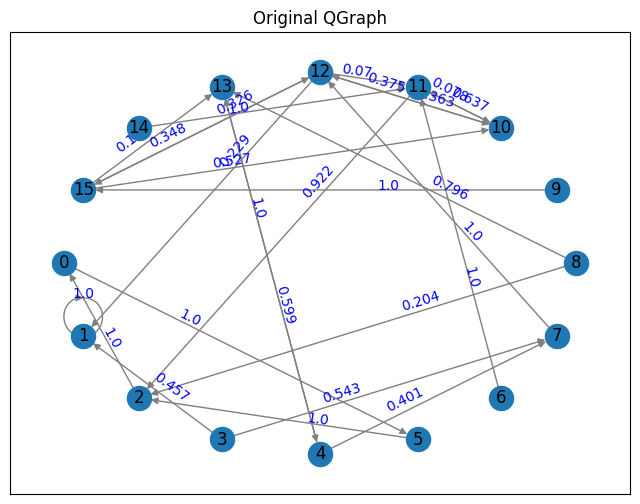

In [7]:
### Loading a graph from a file
G_ID = '016_025_v011'
G_path = f'{GRAPH_PATH}/digraph_{G_ID}/wei.json'
G = load_digraph(G_path)
draw_weighted_digraph(G, 'weight', ax=None, title='Original QGraph')
print(f'Loaded graph from file: {G_path}')

In [8]:
### Recover the original graphs specs (which changed after adding loops)
graph_vertices = int(G_ID[:3])
graph_edges = int(G_ID[4:7])
graph_vers = int(G_ID[-3:])
if info_level > 0: print(f'\nOrg vertices: {graph_vertices}, Org edges = {graph_edges}, Org version = {graph_vers}\n')


Org vertices: 16, Org edges = 25, Org version = 11



In [9]:
### Find the actual graph details
G_dets = digraph_details(G)
n_vertices = len(G_dets['nodes'])
n_edges = len(G_dets['links'])
calc_p = n_edges / n_vertices**2
if info_level > 1: display(G_dets)
if info_level > 0: print(f'\nVertices: {n_vertices}, Edges = {n_edges}, Version = {graph_vers} (calculated p = {np.round(calc_p, 2)})\n')


Vertices: 16, Edges = 26, Version = 11 (calculated p = 0.1)



## QGraph training parameters

In [10]:
n_data = int(np.ceil(np.log2(n_vertices)))
n_extra = 1
n_wires = n_data+n_extra
n_layers = 3
rot = 'Rxyz'
mode = 'hybrid'

iters = 10
epochs = 2000
log_interv = 10
scaler = np.pi
shots = 1000 # ignored for state vector
seed = 2024
thr = 0.05 # Optimum to br determined

### Define devices

In [11]:
### Find what devices are available

# Type to be used with tensors
dtype = torch.float64
torch.set_default_dtype(dtype)

# Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if info_level > 0: print(f'\nThe optimum devices: {sim} and {torch_device}')

# Force CPU to avoid moving computation and data back and from the GPU
torch_device = "cpu"

if info_level > 0: print(f'Devices to be used:  {sim} and {torch_device}\n')


The optimum devices: default.qubit and cuda:0
Devices to be used:  default.qubit and cpu



In [12]:
# ### Counts the number of purely pytorch model parameters
# def count_params(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ### Gets all pytorch parameters
# def get_param_vals(model):
#     params = []
#     for param in model.parameters():
#         params.append(param.view(-1))
#     params = torch.cat(params)
#     params = params.cpu().detach().flatten() # [0]
#     return params.numpy()

In [13]:
# ### Converts a list/array of numbers to a list of their binary representations as a list
# def nums_to_bin_tensor(num_list, n_data, torch_device='cpu'):
#     bin_list_list = np.array([bin_int_to_list(n, n_data) for n in num_list])
#     tens_list = torch.tensor(bin_list_list, dtype=torch.double)
#     return tens_list.to(torch_device)

# ### Test
# if info_level > 2: 
#     test_ts = [1, 3, 6, 7]
#     test_bin = 4
#     print(f'Convert tensor to binary representation:\nnums_to_bin_tensor({test_ts}, {test_bin}) = \n\n{nums_to_bin_tensor(test_ts, test_bin)}\n')

### Prepare data for QGraph training

In [14]:
### Convert the graph to its adjacency matrix
adj_mat = digraph_to_adjmat(G)

### Prepare X and Y vectors for training
X = nums_to_bin_tensor(range(adj_mat.shape[0]), n_data, torch_device=torch_device)
Y = torch.tensor(adj_mat, dtype=torch.double)
if info_level > 2: print(X[0:5],'\n\n',Y[0:5])

### Create and Test a QGraph Quantum Circuit

The qgraph circuit will be a simple QNN. A few different approaches will be tested as determined by the input encoding.
- Simple encoding, with each vertex mapped into a qubit - requires $|V|$ qubits
- Basis encoding, with each vertex number mapped into a binary qubit representation - requires $log_2(|V|)$ qubits

In [15]:
### QGraph wrapper with a static data structure and variant input and weights only
#   wires: circuit wires
#   n_data: number of data wires to be reserved
#   n_extra: number of extra wires to be used in training
#   n_layers: number of entangling layers to be produced
#   rot: rotation type, either 'Ry' or 'Rxyz'
#   scaler: scaler to be applied to the inputs
def qgraph_basis(wires, n_data, n_extra, n_layers=1, rot='Ry', scaler=np.pi):
    
    def _qgraph_circ(inputs, weights):
        # inputs: A single number, being a scaled (down) vertex id
        #         Note that when a NN generates inputs, its results will be in range [-1..1]
        # output: probability distribution of applying the circuit shot number of times
        nonlocal wires, n_data, n_extra, n_layers, rot, scaler
        
        n_learn = n_data + n_extra
        data_wires = wires[0:n_data]
        learn_wires = wires[0:n_learn]
        scaled_inputs = torch.mul(inputs, scaler)
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)
        
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, rotation=qml.RY, wires=learn_wires)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=learn_wires)
        # return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
        return qml.probs(wires=data_wires)
    return _qgraph_circ

def qgraph_basis_shape(n_data, n_extra, n_layers=1, rot='Ry'):
    n_wires = n_data + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        shape = (0)
    return shape

In [16]:
### Create a test model

shape = qgraph_basis_shape(n_data, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)

vertex = nums_to_bin_tensor([5], n_data, torch_device=torch_device)
vertices = nums_to_bin_tensor([2, 3, 6, 7], n_data, torch_device=torch_device)
weights = torch.rand(shape, requires_grad=True)

if info_level > 0: print(f'QGraph shape: {shape}, Epochs: {epochs}, Shots: {shots}, Seed: {seed}, Mode: {mode}')

QGraph shape: (3, 5, 3), Epochs: 2000, Shots: 1000, Seed: 2024, Mode: hybrid


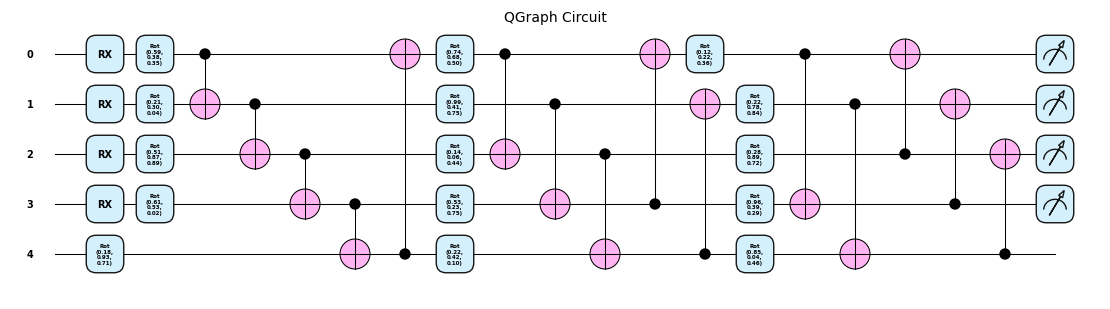

In [17]:
### Testing QGraph for training

# Define a static QGraph
qgraph = qgraph_basis(range(n_wires), n_data, n_extra, n_layers=n_layers, rot=rot, scaler=scaler)

# Create and draw a QGraph circuit
dev = qml.device(sim, wires=n_wires, shots=shots)
qgraph_qc = qml.QNode(qgraph, dev, interface='torch') #, level='gradient')

if info_level > 0:
    dc = draw_circuit(qgraph_qc, scale=0.5, title='QGraph Circuit', level='device') # device # gradient
    dc(vertex, weights) # expansion_strategy='device'/'gradient'

In [18]:
###### Test the circuit
if info_level > 2:
    probs = qgraph_qc(vertices, weights)
    print(f'\nParameters: Scaler={np.round(scaler, 4)}, n_data={n_data}\n')
    print(f'Inputs:\n{vertices}\n')
    print(f'Weights {weights.detach().numpy().shape}: \n{weights}\n')
    print(f'Outputs: probability distributions=\n{probs}\nsum(probs)={[np.round(sum(p).item(), 3) for p in probs]}\n')

## Create and Test QGraph Trainable Model
The generated model can be Classical / Quantum / Hybrid

In [19]:
##### Hybrid QGraph
#
#   Graph properties:
#      wires: circuit wires
#      n_data: number of data wires to be reserved
#      n_extra: number of extra wires to be used in training
#      n_layers: number of entangling layers to be produced
#      rot: rotation type, either 'Ry' or 'Rxyz'
#      scaler: scaler to be applied to all inputs
#      mode: QGraph type, i.e. 'classic', 'quantum' or 'hybrid'
#
#   Circuit functionality (input -> output):
#      input - vertex id (log2N qubits)
#      output - edge weight distribution / probability distribution of target vertex selection (N results)
class qgraph_model(nn.Module):

    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_model, self).__init__()

        self.qg_mode = 'q'
        self.sim = sim
        self.n_data = n_data
        self.n_extra = n_extra
        self.n_wires = n_data+n_extra
        self.wires = list(range(n_wires))
        self.n_layers = n_layers
        self.rot = rot
        self.shots = shots
        self.scaler = scaler

        # Create the model
        def_qlayer = self.qlayer()
        layers = self.layers(def_qlayer)        
        self.model = nn.Sequential(*layers)  

    ### Define an optional (default) quantum layer
    def qlayer(self):
        # Define QGraph circuit weight shapes
        tensor_shape = qgraph_basis_shape(self.n_data, self.n_extra, n_layers=self.n_layers, rot=self.rot)
        weights_shapes = {"weights": tensor_shape}
        init_method = {"weights": torch.rand(tensor_shape, requires_grad=True)} # torch.nn.init.normal_ # torch.nn.init.uniform_

        # Define QGraph circuit and its layer
        qgraph = qgraph_basis(self.wires, self.n_data, self.n_extra, n_layers=self.n_layers, rot=self.rot, scaler=self.scaler)
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)
        qgraph_node = qml.QNode(qgraph, dev, interface='torch') #, diff_method='spsa') #, level='gradient')
        qlayer = qml.qnn.TorchLayer(qgraph_node, weight_shapes=weights_shapes, init_method=init_method)
        return qlayer
        
    ### Define all qgraph layers and return their list
    def layers(self, qlayer):
        ### Default only a quantum layer
        return [qlayer]

    ### Set or return the qgraph mode (any string)
    def mode(self, vmode=None):
        if vmode is not None:
            self.qg_mode = vmode
        return self.qg_mode

    ### Apply the model to data
    def forward(self, x):
        x = self.model(x)
        return x

#####
##### Several subclassess to illustrate how to vary the model
#####

class qgraph_classic_8(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_8, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('c8')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        clayer_0 = torch.nn.Linear(self.n_data, self.n_data)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(self.n_data, 20)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(20, self.n_data)
        clayer_5 = torch.nn.Linear(self.n_data, 2**self.n_data)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4, clayer_5]
        return layers

class qgraph_classic_8_softmax(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_8_softmax, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('cs8')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        clayer_0 = torch.nn.Linear(self.n_data, self.n_data)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(self.n_data, 20)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(20, self.n_data)
        clayer_5 = torch.nn.Linear(self.n_data, 2**self.n_data)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4, clayer_5]
        return layers

    def forward(self, x):
        x = self.model(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

class qgraph_quantum_8(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_quantum_8, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('q8')

    def layers(self, qlayer):        
        layers = [qlayer]
        return layers

class qgraph_hybrid_8(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_hybrid_8, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('hs8')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        clayer_0 = torch.nn.Linear(self.n_data, self.n_data)
        clayer_1 = torch.nn.ReLU()
        clayer_2 = torch.nn.Linear(self.n_data, 20)
        clayer_3 = torch.nn.ReLU()
        clayer_4 = torch.nn.Linear(20, self.n_data)
        
        layers = [clayer_0, clayer_1, clayer_2, clayer_3, clayer_4, qlayer]
        return layers

class qgraph_classic_16(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_16, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('c16')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        slayer_0 = torch.nn.Linear(self.n_data, 50)
        slayer_1 = torch.nn.ReLU()
        slayer_2 = torch.nn.Linear(50, 100)
        slayer_3 = torch.nn.ReLU()
        slayer_4 = torch.nn.Linear(100, 50)
        slayer_5 = torch.nn.ReLU()
        slayer_6 = torch.nn.Linear(50, self.n_data)
        slayer_7 = torch.nn.Linear(50, 2**self.n_data)
        
        layers = [slayer_0, slayer_1, slayer_2, slayer_3, slayer_4, slayer_5, slayer_7]
        return layers

class qgraph_classic_16_softmax(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_classic_16_softmax, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('cs16')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        slayer_0 = torch.nn.Linear(self.n_data, 50)
        slayer_1 = torch.nn.ReLU()
        slayer_2 = torch.nn.Linear(50, 100)
        slayer_3 = torch.nn.ReLU()
        slayer_4 = torch.nn.Linear(100, 50)
        slayer_5 = torch.nn.ReLU()
        slayer_6 = torch.nn.Linear(50, self.n_data)
        slayer_7 = torch.nn.Linear(50, 2**self.n_data)
        
        layers = [slayer_0, slayer_1, slayer_2, slayer_3, slayer_4, slayer_5, slayer_7]
        return layers

    def forward(self, x):
        x = self.model(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

class qgraph_quantum_16(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_quantum_16, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('q16')

    def layers(self, qlayer):        
        layers = [qlayer]
        return layers

class qgraph_hybrid_16(qgraph_model):
    def __init__(self, sim, n_data, n_extra, n_layers=1, rot='Ry', shots=0, scaler=np.pi):
        super(qgraph_hybrid_16, self).__init__(sim, n_data, n_extra, n_layers, rot, shots, scaler)
        self.mode('h16')

    def layers(self, qlayer):
        # Define all layers including QNN layer
        slayer_0 = torch.nn.Linear(self.n_data, 50)
        slayer_1 = torch.nn.ReLU()
        slayer_2 = torch.nn.Linear(50, 100)
        slayer_3 = torch.nn.ReLU()
        slayer_4 = torch.nn.Linear(100, 50)
        slayer_5 = torch.nn.ReLU()
        slayer_6 = torch.nn.Linear(50, self.n_data)
        
        layers = [slayer_0, slayer_1, slayer_2, slayer_3, slayer_4, slayer_5, slayer_6, qlayer]
        return layers


In [20]:
### Trains QGraph models
#   X: Vertex number (from 0 to max)
#   Y: Array(0..max) of (expected) edge weights to all other vertices (including the self)
#
#   Notes:
#   - To save the model state / parameters
#     torch.save(qgraph.state_dict(), PATH)
#     torch.save(opt_params, PATH)
#   - To load the model state / parameters
#     torch.load(PATH, weights_only=True)
#     qgraph.load_state_dict(opt_params, strict=False)
#   - To check the model state / parmeters
#     qgraph.state_dict()

def train_model(model, lossfun, optimizer, X, Y, epochs=50, log_interv=100, prompt_fract=0.1, info_level=1):
    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):

        optimizer.zero_grad()
        output = model(X)
        loss = lossfun(output, Y)
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            if info_level > 0: print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)

### Remind the QAE params

In [21]:
if info_level > 0:
    print(f'\nModel training hyper-parameters:\n'+
        f'\n'+
        f'G_ID = "{G_ID}"\n'+
        f'G_path = "{G_path}"\n'+
        f'n_vertices = {n_vertices}\n'+
        f'n_edges = {n_edges}\n'+
        f'\n'+
        f'n_layers = {n_layers}\n'+
        f'n_data = {n_data}\n'+
        f'n_extra = {n_extra}\n'+
        f'n_wires = {n_wires}\n'+
        f'rot = "{rot}"\n'+
        # f'mode = "{mode}"\n'+
        f'\n'+
        f'scaler = {scaler}\n'+
        f'shots = {shots}\n'+
        f'seed = {seed}\n'+
        f'epochs = {epochs}\n'+
        f'log_interv = {log_interv}\n'+
        f'')


Model training hyper-parameters:

G_ID = "016_025_v011"
G_path = "logs/graph/digraph_016_025_v011/wei.json"
n_vertices = 16
n_edges = 26

n_layers = 3
n_data = 4
n_extra = 1
n_wires = 5
rot = "Rxyz"

scaler = 3.141592653589793
shots = 1000
seed = 2024
epochs = 2000
log_interv = 10



## Train the model

In [22]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Test data only
# epochs = 2000
# rot = 'Rxyz'
# log_interv = 10

### Create a model
# qgraph = qgraph_model(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_quantum_8(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_8(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_8_softmax(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_hybrid_8(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_quantum_16(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_16(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
# qgraph = qgraph_classic_16_softmax(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)
qgraph = qgraph_hybrid_16(sim, n_data, n_extra, n_layers=n_layers, rot=rot).double().to(torch_device)

### Loss and optimiser

lossfun = nn.MSELoss()
# lossfun = nn.L1Loss()
# lossfun = div_metrics().jsd

# optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
optimizer = optim.Adam(qgraph.parameters())

if info_level > 0: display(qgraph.eval())

qgraph_hybrid_16(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=4, bias=True)
    (7): <Quantum Torch Layer: func=_qgraph_circ>
  )
)

In [23]:
### All created files have the following codes:
#   v: vertices
#   e: edges
#   m: mode = 1st letter of quantum / classic / hybrid
#   n: # of data wires
#   x: # of extra wires
#   lays: # of layers
#   rot: rotation type = Ry / Rxyz
#   ep: # of training epochs

mode = qgraph.mode()
lossfun_name = lossfun.__class__.__name__
optimizer_name = optimizer.__class__.__name__

TRAIN_PREF = f'{CASE_NAME}_{DATA_NAME}_{graph_vertices:03d}_{graph_edges:03d}_v{graph_vers:03d}_n{n_data:03d}_x{n_extra:03d}_lays{n_layers:03d}_{rot}_{mode}_ep{epochs}'
if info_level > 0: print(TRAIN_PREF)

bench_rand_016_025_v011_n004_x001_lays003_Rxyz_h16_ep2000


In [24]:
### Train the model
start = time.time()

hist_loss, opt_params, hist_params, opt_point = \
    train_model(qgraph, lossfun, optimizer, X, Y, epochs=epochs, log_interv=log_interv, prompt_fract=0.05, info_level=info_level)

elapsed = time.time() - start

# Print run statistics
shape = qgraph_basis_shape(n_data, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)

if info_level > 0:
    print(f'\n'+
          f'{sim} & {torch_device} Fit ('+
          f'{X.shape[0]} samples, '+
          f'{n_data}+{n_extra}={n_wires} qubits, '+
          f'{n_weights} params, '+
          f'{epochs} epochs): '+
          f'{round(opt_point[1], 5)} min cost @ iter# {opt_point[0]}, '+
          f'{elapsed:0.2f} sec'+
          f'\n'
         )

epoch 0 	 Loss: 0.04866
epoch 100 	 Loss: 0.03281
epoch 200 	 Loss: 0.02828
epoch 300 	 Loss: 0.02548
epoch 400 	 Loss: 0.02106
epoch 500 	 Loss: 0.0162
epoch 600 	 Loss: 0.01424
epoch 700 	 Loss: 0.01337
epoch 800 	 Loss: 0.01291
epoch 900 	 Loss: 0.01266
epoch 1000 	 Loss: 0.01253
epoch 1100 	 Loss: 0.01246
epoch 1200 	 Loss: 0.01242
epoch 1300 	 Loss: 0.0124
epoch 1400 	 Loss: 0.01239
epoch 1500 	 Loss: 0.01238
epoch 1600 	 Loss: 0.01237
epoch 1700 	 Loss: 0.01237
epoch 1800 	 Loss: 0.01237
epoch 1900 	 Loss: 0.01237

default.qubit & cpu Fit (16 samples, 4+1=5 qubits, 45 params, 2000 epochs): 0.01237 min cost @ iter# 1999, 17.88 sec



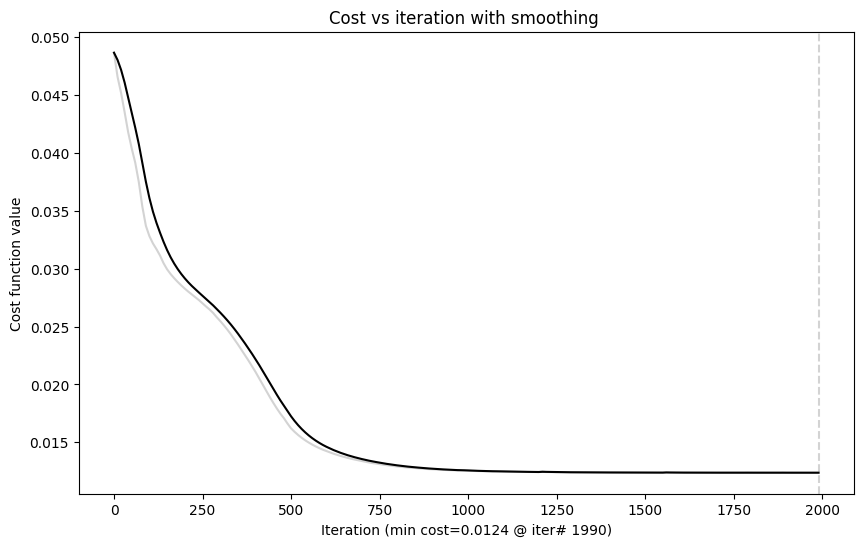

In [25]:
cost_plot(hist_loss, rcParams=(10, 6), backplot=True, back_color='lightgray', smooth_weight=0.7, log_interv=log_interv, 
          save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/hist_{epochs}.eps')

## Find optimum threshold
*Investigate the (lower) weight threshold at which it is considered there is no edge between vertices*

In [26]:
def matprint(mat, fmt="07.5f", addsum=True):
    matsum = np.zeros(mat.shape[0])
    for r in range(mat.shape[0]):
        matsum[r] = mat[r].sum()
    for r in range(mat.shape[0]):
        x = mat[r]
        for i, y in enumerate(x):
            print(("{:"+fmt+"}").format(y), end="  ")
        if addsum:
            print('sum = ', ("{:"+fmt+"}").format(matsum[r]), end="  ")
        print("")

In [27]:
### Apply a metric to (expect, result) pairs, eliminating small values 
###    according to a list of thresholds
def thr_metrics_results(expect, result, thr_list, metric):
    met_vals = []
    for thr in thr_list:
        if type(result) is torch.Tensor:
            opt_result = result.clone()
        else:
            opt_result = result.copy()
        opt_result[abs(opt_result.real) < thr] = 0.0        
        opt_result = digraph_adj_norm(opt_result) # Normalise result
        met_val = metric(expect, opt_result)
        met_vals.append(met_val)
    return np.array(met_vals)

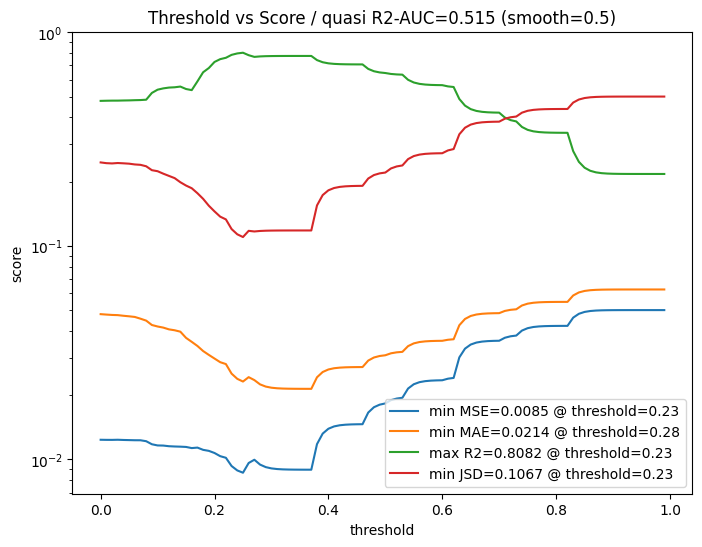

In [28]:
### Calculate threshold vs MSE, MAE, R2, JSD
### Find the optimum threshold and quasi-AUC

from sklearn.metrics import auc, mean_squared_error, mean_absolute_error, r2_score
jsd_score = div_metrics().jsd

### Retrieve expected and observed digraph weights
expect = Y.detach().numpy()
result = qgraph(X).detach().numpy()

### Calculate stats for different threshold levels
thr_dx = 1.0/100
thr_list = np.arange(0.0, 1.0, thr_dx).numpy()
mse_scores = thr_metrics_results(expect, result, thr_list, mean_squared_error)
mae_scores = thr_metrics_results(expect, result, thr_list, mean_absolute_error)
r2_scores = thr_metrics_results(expect, result, thr_list, r2_score)
jsd_scores = thr_metrics_results(torch.tensor(expect), torch.tensor(result), thr_list, jsd_score)

title = f'Threshold vs Score / quasi R2-AUC={np.round(auc(thr_list,r2_scores), 3)}'
multi_perform_plot([mse_scores, mae_scores, r2_scores, jsd_scores], log_interv=[thr_dx]*4,
                   meas_min=[True, True, False, True], labels=['MSE', 'MAE', 'R2', 'JSD'], 
                   title=title, meas_type='score', xlabel='threshold',
                   backplot=False, smooth_weight=0.5,
                   back_color='linen', line_styles=None, line_cols=None, 
                   rcParams=(8, 6), yscale='log', xlim=None, ylim=None, 
                   save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/thr_vs_r2auc.eps')

In [29]:
### Find the optimum threshold
mse_min = np.min(mse_scores)
mse_min_idx = np.argmin(mse_scores)
opt_thr = thr_list[mse_min_idx]
if info_level > 0: print(f'Min MSE={np.round(mse_min, 4)} @ thr[{mse_min_idx}]={np.round(opt_thr, 4)}')

Min MSE=0.0085 @ thr[23]=0.23


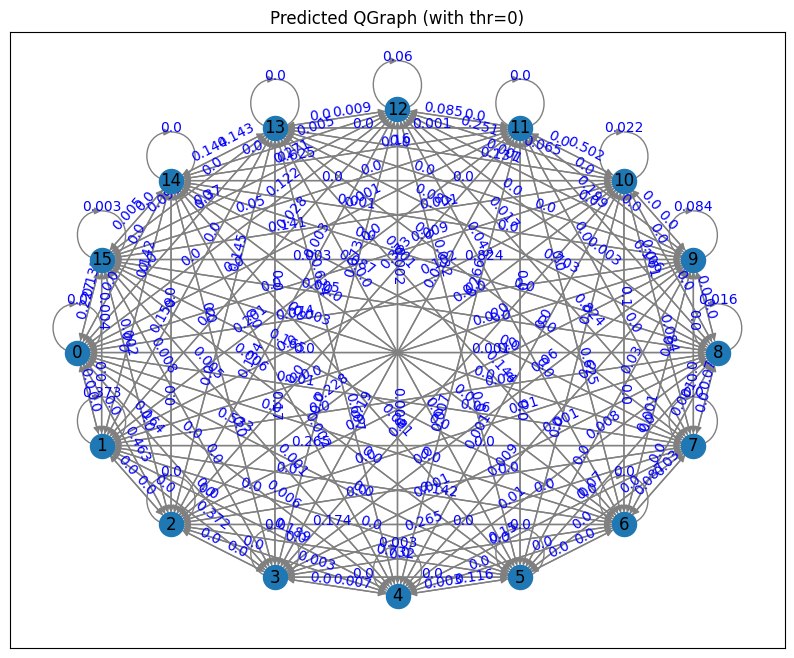

In [30]:
### Show the resulting "predicted" graph
res_G = nx.from_numpy_array(result, create_using=nx.DiGraph)

### Compare the original and resulting graph
# draw_weighted_digraphs([G, res_G], titles=['Original digraph', f'Predicted digraph (with thr={0})'],
#                        attr_name='weight', rcParams=(16, 6), save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/graph_org_vs_pred_{epochs}.eps')
draw_weighted_digraph(res_G, title=f'Predicted QGraph (with thr={0})',
                       attr_name='weight', rcParams=(10, 8), save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/graph_pred_{epochs}.eps')

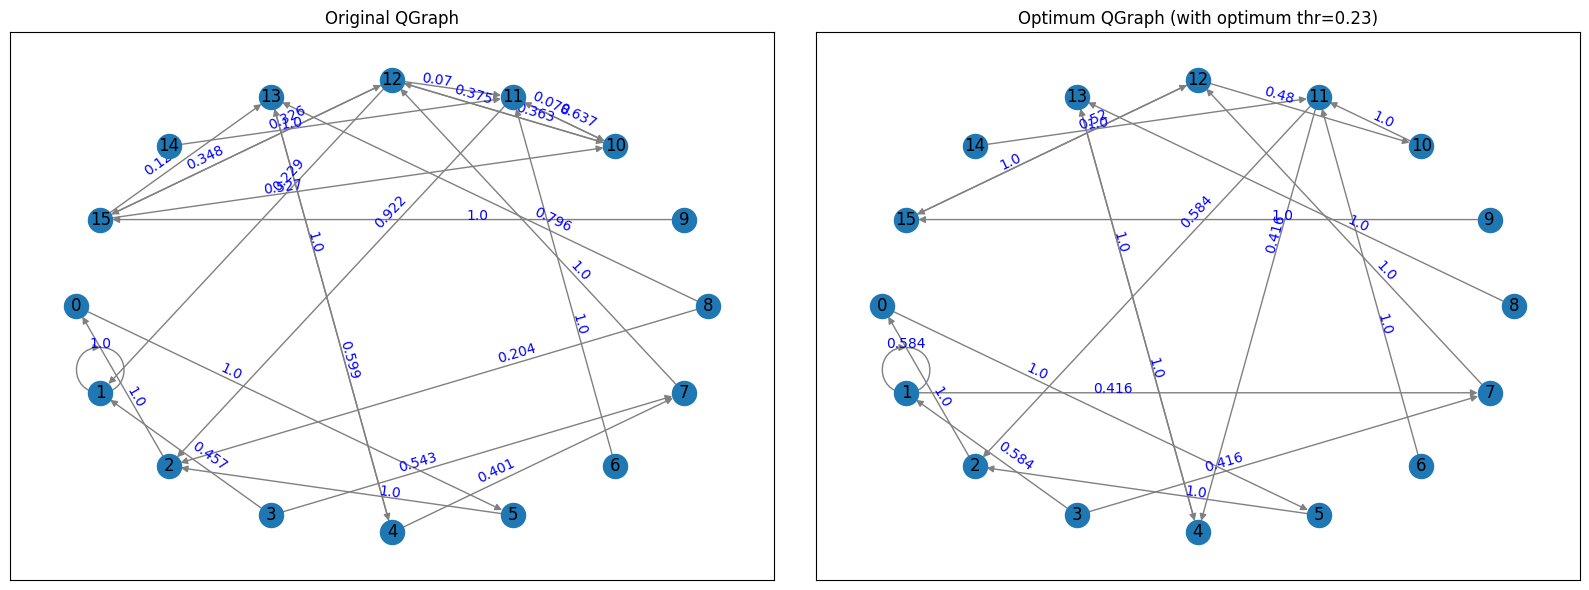

In [31]:
### Find the resulting graph (in relation to the threshold)
opt_result = result.copy()
opt_result[abs(opt_result.real) < opt_thr] = 0.0

### Normalise result
opt_result = digraph_adj_norm(opt_result)

opt_G = nx.from_numpy_array(opt_result, create_using=nx.DiGraph)

### Compare the original and resulting graph
draw_weighted_digraphs([G, opt_G], titles=['Original QGraph', f'Optimum QGraph (with optimum thr={np.round(opt_thr, 4)})'],
                       attr_name='weight', rcParams=(16, 6), save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/graph_org_vs_opt_{epochs}.eps')

## Save training data

In [32]:
### Save training parameters
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/qopt_params.pkl', opt_params)
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/qhist_params.pkl', hist_params)
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/qopt_point.pkl', opt_point)
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/qhist_loss.pkl', hist_loss)

In [33]:
### Save threshold scores
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/thr_mse_scores.pkl', mse_scores)
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/thr_mae_scores.pkl', mae_scores)
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/thr_r2_scores.pkl', r2_scores)
write_obj_file(f'{TRAIN_PATH}/{TRAIN_PREF}/thr_jsd_scores.pkl', jsd_scores)

In [34]:
### Save resulting and optimum graph
save_digraph(res_G, f'{GRAPH_PATH}/digraph_{G_ID}/res.json')
save_digraph(opt_G, f'{GRAPH_PATH}/digraph_{G_ID}/opt.json')

In [35]:
### Save training info
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':MAJOR, 
     'minor_version':MINOR,
     'data_name':DATA_NAME,
     
     'graph_id':G_ID,
     'graph_version':graph_vers,
     'graph_vertices':n_vertices,
     'graph_edges':n_edges,
     'graph_p':calc_p,
     
     'n_data':n_data,
     'n_extra':n_extra,
     'n_wires':n_wires,
     'n_layers':n_layers,
     'rot':rot,
     'mode':mode,
     
     'iters':iters,
     'epochs':epochs,
     'log_interv':log_interv,
     'scaler':scaler,
     'shots':shots,
     'seed':seed,
     'opt_thr':opt_thr,
     'opt_loss':lossfun.__class__.__name__,
     'opt_name':optimizer.__class__.__name__,
    }

### Saving the info file
info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}/info.json'
write_json_file(info_fpath, train_info)
    
print(f'\nSaved training info in file "{info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved training info in file "logs/training/bench_rand_016_025_v011_n004_x001_lays003_Rxyz_h16_ep2000/info.json":

	info[case_name] = bench
	info[major_version] = 1
	info[minor_version] = 14
	info[data_name] = rand
	info[graph_id] = 016_025_v011
	info[graph_version] = 11
	info[graph_vertices] = 16
	info[graph_edges] = 26
	info[graph_p] = 0.1015625
	info[n_data] = 4
	info[n_extra] = 1
	info[n_wires] = 5
	info[n_layers] = 3
	info[rot] = Rxyz
	info[mode] = h16
	info[iters] = 10
	info[epochs] = 2000
	info[log_interv] = 10
	info[scaler] = 3.141592653589793
	info[shots] = 1000
	info[seed] = 2024
	info[opt_thr] = 0.23
	info[opt_loss] = MSELoss
	info[opt_name] = Adam



## Issues

**V1_XX** Training
- Fixed 01 (240908) Model params not matching input - need to change the QG representation
  - Recoded QG representation, problem fixed
- Fixed 02 (240909) Error in classical and hybrid QG mode
  - That was a bad ref to NN layer in testing
- Fixed 03 (240909) QG accuracy calculated and compared
- Fixed 04 (240909) Need to apply KL and/or JS divergence as the loss function
  - Tested with JS, works well in quantum and hybrid mode
- Fixed 05 (240909) Poor QG performance
  - Performance improved in all modes, especially in hybrid mode with JSD<br/>
- Fixed 06 (240909) Math domain error in JSD when classic mode used<br/>
  - In classic mode, negative "Ps" were generated causing errors in log2, changed tests to include P > 0
  - A different error was generated, where the sum(results) <> 1, softmax was applied in forward and error fixed
- Fixed 07 (240909) Larger graph needs to be tested
  - Successfully used a graph with 16 nodes and 33 edges, which doubled the processing time (865 vs 404 secs)
- Fixed 08 (240909) Erroneous tensor generation after moving bit / list conversion to Circuits
  - As PennyLane was capturing numpy, a separate numpy_np was declared and error cleared
- Fixed 09 (240911) Compare side-by-side expected vs observed weight distributions
- Fixed 10 (240911) Fixed classic model with JSD by adding softmax, plus saves model performance and params to logs
- Fixed 11 (240912) Included side-by-side comparison of the expected vs observed weight distributions
- Fixed 12 (241219) Added several performance scores
- Fixed 13 (241224) Added saving performance measures
- Fixed 14 (241230) Normalise resulting graphs, split the analysis away from training

## System

In [36]:
import sys
print(f'Environment:\n\n{sys.prefix}\n')

Environment:

/home/jacob/miniconda3/envs/pl-cuda12



In [37]:
import os
print(f"Significant packages:\n")
os.system('pip list | grep -e torch -e PennyLane -e networkx');

Significant packages:

networkx                  3.4.2
PennyLane                 0.39.0
PennyLane_Lightning       0.39.0
PennyLane_Lightning_GPU   0.39.0
PennyLane-Rigetti         0.39.0
torch                     2.5.1
torch_geometric           2.5.3
torchaudio                2.5.1
torcheval                 0.0.7
torchsummary              1.5.1
torchvision               0.20.1
